# 1D Scene

We now consider 1D driving scenes on wraparound roadways.

In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Base.Test

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.5/AutoScenes.ji for module AutoScenes.


### Entity

We define our entity with a 1D state containing both position $s \in [0,50] m$ and a speed $v \in [0, 32] m/s$.
The vehicles have bounding box definitions and integer ids.

In [2]:
const Vehicle1D = Entity{PosSpeed1D, BoundingBoxDef, Int}
const Scene1D = Frame{Vehicle1D};

We construct a sample scene.

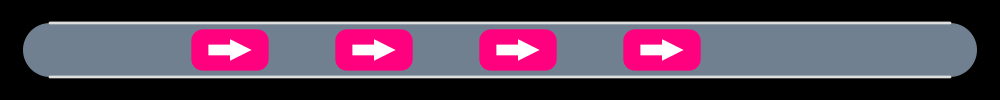

In [3]:
def = BoundingBoxDef(AgentClass.CAR, 4.0, 2.0)
roadway = Wraparound(Straight1DRoadway(50.0))
scene = Frame([
    Vehicle1D(PosSpeed1D(10.0,10.0), def, 1),
    Vehicle1D(PosSpeed1D(18.0,12.0), def, 2),
    Vehicle1D(PosSpeed1D(26.0,10.0), def, 3),
    Vehicle1D(PosSpeed1D(34.0, 8.0), def, 4),
])
render(scene, Straight1DRoadway(50.0), cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)

We can construct a lead-follow relationship to help us assign the features. This is supplied by AutoScenes.jl

In [4]:
lead_follow = LeadFollowRelationships(scene, roadway)
@test lead_follow.index_fore == [2,3,4,1]
@test lead_follow.index_rear == [4,1,2,3]

Test Passed
  Expression: lead_follow.index_rear == [4,1,2,3]
   Evaluated: [4,1,2,3] == [4,1,2,3]

Our variables are the position $s$ and speed $v$ for each vehicle.
The position is bounded by the position of the lead and trailing vehicle.

In [5]:
function AutoScenes.Vars(scene::Scene1D, roadway::Wraparound{Straight1DRoadway})

    n = length(scene)
    vars = Vars(Array(Float64, 2n),
                Array(StateBounds, 2n),
                Array(Symbol, 2n),
                Array(Int, 2n))

    lead_follow = LeadFollowRelationships(scene, roadway)

    j = 0
    for (vehicle_index, veh) in enumerate(scene)

        rear = scene[lead_follow.index_rear[vehicle_index]]
        fore = scene[lead_follow.index_fore[vehicle_index]]

        Δs_fore = get_headway(veh, fore, roadway)
        Δs_rear = get_headway(rear, veh, roadway)

        # position
        j += 1
        vars.values[j] = veh.state.s
        vars.bounds[j] = StateBounds(-Δs_rear, Δs_fore)
        vars.symbols[j] = :s
        vars.vehicle_indices[j] = vehicle_index
        @assert vars.bounds[j].Δlo ≤ 0.0
        @assert vars.bounds[j].Δhi ≥ 0.0

        # speed
        j += 1
        vars.values[j] = veh.state.v
        vars.bounds[j] = StateBounds(0.0 - veh.state.v, 32.0 - veh.state.v)
        vars.symbols[j] = :v
        vars.vehicle_indices[j] = vehicle_index
        @assert vars.bounds[j].Δlo ≤ 0.0
        @assert vars.bounds[j].Δhi ≥ 0.0
    end

    return vars
end

vars = Vars(scene, roadway)
@test vars.values ≈ [10.0, 10.0, 18.0, 12.0, 26.0, 10.0, 34.0, 8.0]
@test vars.symbols == [:s, :v, :s, :v, :s, :v, :s, :v]
@test vars.vehicle_indices == [1, 1, 2, 2, 3, 3, 4, 4]
@test vars.bounds[1] == StateBounds(-(50-34+10-4.0),4.0)
@test vars.bounds[2] == StateBounds(-10.0, 22.0)
@test vars.bounds[3] == StateBounds(-4.0, 4.0)

Test Passed
  Expression: vars.bounds[3] == StateBounds(-4.0,4.0)
   Evaluated: AutoScenes.StateBounds(-4.0,4.0) == AutoScenes.StateBounds(-4.0,4.0)

Let us begin by implementing a speed feature and a delta speed feature:

In [6]:
function speed{R}(
    vars::Vars,
    assignment::Assignment, # indeces of variables in vars
    roadway::R,
    )

    return vars.values[assignment[1]]
end
function AutoScenes.assign_feature{F <: typeof(speed), R}(
    f::F,
    scene::Scene1D,
    roadway::R,
    vars::Vars,
    )

    assignments = Assignment[]
    for (i, sym) in enumerate(vars.symbols)
        if sym == :v
            push!(assignments, (i,0))
        end
    end

    return assignments
end

assignments_speed = assign_feature(speed, scene, roadway, vars)
@test assignments_speed == [(2,0), (4,0), (6,0), (8,0)]
@test speed(vars, assignments_speed[1], roadway) ≈ 10.0
@test speed(vars, assignments_speed[2], roadway) ≈ 12.0
@test speed(vars, assignments_speed[3], roadway) ≈ 10.0
@test speed(vars, assignments_speed[4], roadway) ≈  8.0

Test Passed
  Expression: speed(vars,assignments_speed[4],roadway) ≈ 8.0
   Evaluated: 8.0 isapprox 8.0

In [7]:
function delta_speed{R}(
    vars::Vars, # all variables
    assignment::Assignment, # indeces of variables in vars
    roadway::R,
    )

    v_rear = vars.values[assignment[1]]
    v_fore = vars.values[assignment[2]]
    return v_fore - v_rear
end
function AutoScenes.assign_feature{F <: typeof(delta_speed)}(
    f::F,
    scene::Scene1D,
    roadway::Wraparound{Straight1DRoadway},
    vars::Vars,
    )

    lead_follow = LeadFollowRelationships(scene, roadway)

    assignments = Assignment[]
    for (vehicle_index, index_fore) in enumerate(lead_follow.index_fore)
        j_rear = findfirst(vars, vehicle_index, :v)
        j_fore = findfirst(vars, index_fore, :v)
        push!(assignments, (j_rear, j_fore))
    end

    return assignments
end

assignments_delta_speed = assign_feature(delta_speed, scene, roadway, vars)
@test assignments_delta_speed == [(2,4), (4,6), (6,8), (8,2)]
@test delta_speed(vars, assignments_delta_speed[1], roadway) ≈ 12.0 - 10.0
@test delta_speed(vars, assignments_delta_speed[2], roadway) ≈ 10.0 - 12.0
@test delta_speed(vars, assignments_delta_speed[3], roadway) ≈  8.0 - 10.0
@test delta_speed(vars, assignments_delta_speed[4], roadway) ≈ 10.0 -  8.0

Test Passed
  Expression: delta_speed(vars,assignments_delta_speed[4],roadway) ≈ 10.0 - 8.0
   Evaluated: 2.0 isapprox 2.0

We continue by assigning features to the scene.

In [8]:
features = (speed, delta_speed)
assignments = assign_features(features, scene, roadway, vars)
@test assignments[1] == (1, (2,0))
@test assignments[2] == (1, (4,0))
@test assignments[3] == (1, (6,0))
@test assignments[4] == (1, (8,0))
@test assignments[5] == (2, (2,4))
@test assignments[6] == (2, (4,6))
@test assignments[7] == (2, (6,8))
@test assignments[8] == (2, (8,2))

Test Passed
  Expression: assignments[8] == (2,(8,2))
   Evaluated: (2,(8,2)) == (2,(8,2))

Above we see that `speed`, the first feature, is assigned to the 2nd, 4th, 6th, and 8th variables. This is because those are the speeds of the four cars.

Next we construct a scope. A scope of a variable lists all of the features that require it. These help us reduce the amount of computation we need to perform.

In [9]:
@test scope(1, assignments) == Int[]
@test scope(2, assignments) == [1,5,8]
@test scope(3, assignments) == Int[]
@test scope(4, assignments) == [2,5,6]
scopes = [scope(var_index, assignments) for var_index in 1 : length(vars)];

#### ptilde

We test $\tilde{p}(s)$

In [10]:
srand(0)
θ = randn(length(features))
@test ptilde(features, θ, vars, assignments, roadway) ≈ exp(
        θ[1] * speed(vars, assignments_speed[1], roadway) +
        θ[1] * speed(vars, assignments_speed[2], roadway) +
        θ[1] * speed(vars, assignments_speed[3], roadway) +
        θ[1] * speed(vars, assignments_speed[4], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[1], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[2], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[3], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[4], roadway)
    )

Test Passed
  Expression: ptilde(features,θ,vars,assignments,roadway) ≈ exp(θ[1] * speed(vars,assignments_speed[1],roadway) + θ[1] * speed(vars,assignments_speed[2],roadway) + θ[1] * speed(vars,assignments_speed[3],roadway) + θ[1] * speed(vars,assignments_speed[4],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[1],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[2],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[3],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[4],roadway))
   Evaluated: 6.270530864822832e11 isapprox 6.270530864822832e11

We can also compute ptilde for a particular scope:

In [11]:
srand(0)
θ = randn(length(features))
@test ptilde(features, θ, vars, assignments, scopes[2], roadway) ≈ exp(
        θ[1] * speed(vars, assignments_speed[1], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[1], roadway) +
        θ[2] * delta_speed(vars, assignments_delta_speed[4], roadway)
    )

Test Passed
  Expression: ptilde(features,θ,vars,assignments,scopes[2],roadway) ≈ exp(θ[1] * speed(vars,assignments_speed[1],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[1],roadway) + θ[2] * delta_speed(vars,assignments_delta_speed[4],roadway))
   Evaluated: 24458.380378875903 isapprox 24458.380378875903

#### Probability Denominator

We will need to calculate:

$$p(v_1 \mid \text{other}) = \frac{\tilde{p}(v_1 \mid \text{other})}{\tilde{p}(\text{other})} = \frac{\tilde{p}(v_1 \mid \text{other})}{\int_{v'_1} \tilde{p}(v'_1 \mid \text{other})\> d v'_1}$$

We compute the denominator first:
$$\begin{aligned}
Z & = \int_{v_1} \tilde{p}(v_1 \mid \text{other})\> d v_1  \\
& = \int_0^{32} exp\left\{\theta_1v'_1 + \theta_1 v_2 + \theta_1 v_3 + \theta_1 v_4 + \theta_2(v_2 - v'_1) + \theta_2(v_3 - v_2)  + \theta_2(v_4 - v_3) + \theta_2(v'_1 - v_4)\right\} \> d v'_1 \\
& = \int_0^{32} exp\left\{\theta_1(v'_1 + v_2 + v_3 + v_4)\right\} \> d v'_1 \\
& = \exp\left\{\theta_1(v_2 + v_3 + v_4)\right\}\int_0^{32} exp\left\{\theta_1 v'_1\right\} \> d v'_1
\end{aligned}
$$

In [12]:
v₁ = vars.values[2]
v₂ = vars.values[4]
v₃ = vars.values[6]
v₄ = vars.values[8]
θ = Float64[1,1]
Z = exp(θ[1]*(v₂ + v₃ + v₄))quadgk(v₁->exp(θ[1]*(v₁)), 0, 32)[1]
Z′ = ptilde_denom(2, features, θ, vars, assignments, roadway)
@test isapprox(Z′, Z, atol=1e-8)

srand(0)
θ = randn(2)
Z = exp(θ[1]*(v₂ + v₃ + v₄))quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z′ = ptilde_denom(2, features, θ, vars, assignments, roadway)
@test isapprox(Z′, Z, atol=1e-8)

Test Passed
  Expression: isapprox(Z′,Z,atol=1.0e-8)

Oftentimes we do not want to compute a bunch of static leading terms. They cancel out with the same term in the numerator of the probability equation above anyway. This is what scopes are for.

$$\begin{aligned}
Z_{v_1} & = \int_{v_1} \tilde{p}_{\text{scope}[v_1]}(v_1 \mid \text{other})\> d v_1  \\
& = \int_0^{32} exp\left\{\theta_1v'_1 + \theta_2(v_2 - v'_1) + \theta_2(v'_1 - v_4)\right\} \> d v'_1 \\
& = \int_0^{32} exp\left\{\theta_1v'_1 + \theta_2(v_2 - v_4)\right\} \> d v'_1 \\
& = \exp\left\{\theta_2(v_2 - v_4)\right\}\int_0^{32} exp\left\{\theta_1 v'_1\right\} \> d v'_1
\end{aligned}
$$

In this case the savings aren't that amazing but it is better in more complicated factor graphs.

In [13]:
θ = Float64[1,1]
Z = exp(θ[2]*(v₂ - v₄))quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z′ = ptilde_denom(2, features, θ, vars, assignments, scopes[2], roadway)
@test isapprox(Z′, Z, atol=1e-8)

srand(0)
θ = randn(2)
Z = exp(θ[1]*(v₂ + v₃ + v₄))quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z′ = ptilde_denom(2, features, θ, vars, assignments, roadway)
@test isapprox(Z′, Z, atol=1e-8)

Test Passed
  Expression: isapprox(Z′,Z,atol=1.0e-8)

#### log pseudolikelihood loss

single instance:
$$
\ell_\text{PL}(s) = \sum_j \ln p(x_j \mid x_{-j}) = \sum_j \left(\ln\tilde{p}(s) - \ln \int_{x'_j} \tilde{p}(x'_j, x_{-j}) \> dx'_{-j}\right)
$$

we further simplify:
$$
\ln p(x_j \mid x_{-j}) = \left(\sum_{i:\text{scope}[f_i] \ni x_j} \theta_i f_i(s)\right) - \ln \left(\int_{x'_j} \sum_{i:\text{scope}[f_i]\ni x_j} \theta_i f_i(x'_j, x_{-j}) \> d x'_j\right)
$$

The log pseudolikelihood loss for this scene is:

$$
\begin{aligned}
\ell_\text{PL} (s) & = \ln p(v_1 \mid \text{other}) + \ln p(v_2 \mid \text{other}) + \ln p(v_3 \mid \text{other}) + \ln p(v_4 \mid \text{other}) \\
& = \left(\theta_1 v_1 + \theta_2(v_2 - v_1) + \theta_2(v_1 - v_4)\right) - \ln Z_{v_1} \\
& \quad + \left(\theta_1 v_2 + \theta_2(v_3 - v_2) + \theta_2(v_2 - v_1)\right) - \ln Z_{v_2} \\
& \quad + \left(\theta_1 v_3 + \theta_2(v_4 - v_3) + \theta_2(v_3 - v_2)\right) - \ln Z_{v_3} \\
& \quad + \left(\theta_1 v_4 + \theta_2(v_1 - v_4) + \theta_2(v_4 - v_3)\right) - \ln Z_{v_4} \\
& = \left(\theta_1 v_1 + \theta_2(v_2 - v_4)\right) - \ln Z_{v_1} \\
& \quad + \left(\theta_1 v_2 + \theta_2(v_3 - v_1)\right) - \ln Z_{v_2} \\
& \quad + \left(\theta_1 v_3 + \theta_2(v_4 - v_2)\right) - \ln Z_{v_3} \\
& \quad + \left(\theta_1 v_4 + \theta_2(v_1 - v_3)\right) - \ln Z_{v_4} \\
& = \theta_1 \left( v_1 + v_2 + v_3 + v_4\right) - \ln Z_{v_1}  - \ln Z_{v_2}  - \ln Z_{v_3}  - \ln Z_{v_4}
\end{aligned}
$$

Note that we ignore calculations for variables with empty scope.

In [14]:
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
Z3 = exp(θ[2]*(v₄ - v₂))*quadgk(v₃->exp(θ[1]*v₃), 0, 32)[1]
Z4 = exp(θ[2]*(v₁ - v₃))*quadgk(v₄->exp(θ[1]*v₄), 0, 32)[1]
plogl = θ[1]*(v₁ + v₂ + v₃ + v₄) - log(Z1) - log(Z2) - log(Z3) - log(Z4)
plogl′ = log_pseudolikelihood(features, θ, vars, assignments, scopes, roadway)
@test isapprox(plogl′, plogl, atol=1e-8)

Test Passed
  Expression: isapprox(plogl′,plogl,atol=1.0e-8)

In [15]:
srand(0)
θ = randn(2)
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
Z3 = exp(θ[2]*(v₄ - v₂))*quadgk(v₃->exp(θ[1]*v₃), 0, 32)[1]
Z4 = exp(θ[2]*(v₁ - v₃))*quadgk(v₄->exp(θ[1]*v₄), 0, 32)[1]
plogl = θ[1]*(v₁ + v₂ + v₃ + v₄) - log(Z1) - log(Z2) - log(Z3) - log(Z4)
plogl′ = log_pseudolikelihood(features, θ, vars, assignments, scopes, roadway)
@test isapprox(plogl′, plogl, atol=1e-8)

Test Passed
  Expression: isapprox(plogl′,plogl,atol=1.0e-8)

#### log psuedolikelihood gradient

Before we compute the log pseudolikelihood gradient, we first compute the expected value: $\mathbb{E}_{x_j \sim p(x_j \mid x_{-j} ; \theta)}[f_i(x_j \mid x_{-j})]$

For $v_1$ this is:

$$
\mathbb{E}_{v_1 \sim p(v_1\mid \text{other})}[f_i(x)] = \int_0^{32} f_i(s) p_\theta(s) \> dv_1 = \frac{1}{Z_{v_1}} \int_0^{32} f_i(s) \tilde{p}_\theta(s) \> dv_1
$$

In [16]:
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
E = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(1, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₁->(v₂ - v₁)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(5, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₁->(v₁ - v₄)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(8, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)

Test Passed
  Expression: isapprox(E′,E,atol=1.0e-8)

In [17]:
srand(0)
θ = randn(2)
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
E = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(1, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₁->(v₂ - v₁)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(5, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₁->(v₁ - v₄)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E′ = calc_expectation_x_given_other(8, 2, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)

Test Passed
  Expression: isapprox(E′,E,atol=1.0e-8)

For $v_2$ this is:
$$
\mathbb{E}_{v_2 \sim p(v_2\mid \text{other})}[f_i(x)] = \int_0^{32} f_i(s) p_\theta(s) \> dv_1 = \frac{1}{Z_{v_1}} \int_0^{32} f_i(s) \tilde{p}_\theta(s) \> dv_1
$$

In [18]:
θ = Float64[1,1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
E = quadgk(v₂->v₂*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
E′ = calc_expectation_x_given_other(2, 4, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₂->(v₃ - v₂)*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
E′ = calc_expectation_x_given_other(6, 4, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)
E = quadgk(v₂->(v₂ - v₁)*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
E′ = calc_expectation_x_given_other(5, 4, features, θ, vars, assignments, roadway)
@test isapprox(E′, E, atol=1e-8)

Test Passed
  Expression: isapprox(E′,E,atol=1.0e-8)

Next we test the log pseudolikleihood gradient:
$$
\frac{\partial}{\partial \theta_i} \ell_\text{PL}(\mathcal{D}) = \sum_{j : x_j \in \text{scope}[f_i]} \left(\frac{1}{M}\sum_m f_i(x_{\cdot}^{(m)}) - \mathbb{E}[f_i(x_j' \mid x_{-j}^{(m)})]\right)
$$

For $f_1$ and a single scene we get:
$$
\begin{aligned}
\frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_1} & = \sum_{j \in \left\{2\right\}} \left( f_1(s) - \mathbb{E}[f_1(x_j' \mid x_{-j})]\right) \\
& = f_1(v_1) - \mathbb{E}[f_1(v_1)] \\
& = v_1 - \mathbb{E}[v_1]
\end{aligned}
$$

In [19]:
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
E = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
∂ = v₁ - E
∂′ = log_pseudolikelihood_derivative_single(1, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

In [20]:
srand(0)
θ = randn(2)
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
E = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
∂ = v₁ - E
∂′ = log_pseudolikelihood_derivative_single(1, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

Similarly, for $f_2$ and a single scene we get:
$$
\begin{aligned}
\frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_2} & = \sum_{j \in \left\{2\right\}} \left( f_2(s) - \mathbb{E}[f_2(x_j' \mid x_{-j})]\right) \\
& = f_2(v_2) - \mathbb{E}[f_2(v_2)] \\
& = v_2 - \mathbb{E}[v_2]
\end{aligned}
$$

In [21]:
θ = Float64[1,1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
E = quadgk(v₂->v₂*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
∂ = v₂ - E
∂′ = log_pseudolikelihood_derivative_single(2, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

In AutoScenes the above is referred to as the single derivative. The complete derivative with respect to $\theta_1$ must consider all features it multiplies:

$$
\frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) = \frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_1} + \frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_2} + \frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_3} + \frac{\partial}{\partial \theta_1} \ell_\text{PL}(s) \biggr\rvert_{f_4}
$$

In [22]:
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
Z3 = exp(θ[2]*(v₄ - v₂))*quadgk(v₃->exp(θ[1]*v₃), 0, 32)[1]
Z4 = exp(θ[2]*(v₁ - v₃))*quadgk(v₄->exp(θ[1]*v₄), 0, 32)[1]
E1 = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E2 = quadgk(v₂->v₂*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
E3 = quadgk(v₃->v₃*exp(θ[1]*v₃ + θ[2]*(v₄ - v₃) + θ[2]*(v₃ - v₂)), 0, 32)[1] / Z3
E4 = quadgk(v₄->v₄*exp(θ[1]*v₄ + θ[2]*(v₁ - v₄) + θ[2]*(v₄ - v₃)), 0, 32)[1] / Z4
∂ = (v₁ - E1) + (v₂ - E2) + (v₃ - E3) + (v₄ - E4)
∂′ = log_pseudolikelihood_derivative_complete(1, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

-21.00000000000041
-19.000000000000405
-21.00000000000041
-23.000000000000398


Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

In [23]:
srand(0)
θ = randn(2)
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
Z3 = exp(θ[2]*(v₄ - v₂))*quadgk(v₃->exp(θ[1]*v₃), 0, 32)[1]
Z4 = exp(θ[2]*(v₁ - v₃))*quadgk(v₄->exp(θ[1]*v₄), 0, 32)[1]
E1 = quadgk(v₁->v₁*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E2 = quadgk(v₂->v₂*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
E3 = quadgk(v₃->v₃*exp(θ[1]*v₃ + θ[2]*(v₄ - v₃) + θ[2]*(v₃ - v₂)), 0, 32)[1] / Z3
E4 = quadgk(v₄->v₄*exp(θ[1]*v₄ + θ[2]*(v₁ - v₄) + θ[2]*(v₄ - v₃)), 0, 32)[1] / Z4
∂ = (v₁ - E1) + (v₂ - E2) + (v₃ - E3) + (v₄ - E4)
∂′ = log_pseudolikelihood_derivative_complete(1, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

-20.52747893229806
-18.52747893229806
-20.527478932298067
-22.527478932298067


Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

The gradient for $\theta_2$ is:

$$
\frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) = \frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) \biggr\rvert_{f_5} + \frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) \biggr\rvert_{f_6} + \frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) \biggr\rvert_{f_7} + \frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) \biggr\rvert_{f_8}
$$

where the first term is:
$$
\begin{aligned}
\frac{\partial}{\partial \theta_2} \ell_\text{PL}(s) \biggr\rvert_{f_5} & = \sum_{j \in \left\{2,4\right\}} \left( f_5(s) - \mathbb{E}[f_5(x_j' \mid x_{-j})]\right) \\
& = 2f_5(v_1, v_2) - \mathbb{E}[f_5(v_1 \mid v_2)]  - \mathbb{E}[f_5(v_2 \mid v_1)] \\
& = 2(v_2 - v_1) - \mathbb{E}[f_5(v_1 \mid v_2)]  - \mathbb{E}[f_5(v_2 \mid v_1)]
\end{aligned}
$$

In [27]:
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
E1 = quadgk(v₁->(v₂ - v₁)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E2 = quadgk(v₂->(v₂ - v₁)*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
∂ = 2(v₂ - v₁) - E1 - E2
∂′ = log_pseudolikelihood_derivative_single(5, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)

In [28]:
srand(0)
θ = randn(2)
θ = Float64[1,1]
Z1 = exp(θ[2]*(v₂ - v₄))*quadgk(v₁->exp(θ[1]*v₁), 0, 32)[1]
Z2 = exp(θ[2]*(v₃ - v₁))*quadgk(v₂->exp(θ[1]*v₂), 0, 32)[1]
E1 = quadgk(v₁->(v₂ - v₁)*exp(θ[1]*v₁ + θ[2]*(v₂ - v₁) + θ[2]*(v₁ - v₄)), 0, 32)[1] / Z1
E2 = quadgk(v₂->(v₂ - v₁)*exp(θ[1]*v₂ + θ[2]*(v₃ - v₂) + θ[2]*(v₂ - v₁)), 0, 32)[1] / Z2
∂ = 2(v₂ - v₁) - E1 - E2
∂′ = log_pseudolikelihood_derivative_single(5, features, θ, vars, assignments, scopes, roadway)
@test isapprox(∂′, ∂, atol=1e-8)

Test Passed
  Expression: isapprox(∂′,∂,atol=1.0e-8)